In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

!pip install shap
import shap
shap.initjs()


import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")



In [4]:
# załadowanie ramki danych

df_all = pd.read_csv('df_all.csv',sep = ';')
df_all = df_all.drop('Column1', axis = 1)
df_all.head(5)

,Close,Comp,Date,ROR_month,ROR_qtr,ROR_half_year,ROR_year,Score,Oil,Gold,USD to Yuan,Category
0,6.163362,UBA,24.03.2004,0.083411,NaN,NaN,NaN,0.741122,37.009998,417.200012,8.267201,8.0
1,7.158419,UBA,15.06.2005,0.087692,0.098211,0.032070,0.254842,0.803913,55.570000,429.100006,8.266501,8.0
2,7.281594,UBA,29.06.2005,0.045381,0.134050,0.014216,0.223035,0.806620,57.259998,NaN,8.266501,8.0
3,7.605220,UBA,13.07.2005,0.066313,0.228741,0.148893,0.219617,0.923381,60.009998,423.899994,8.266501,8.0
4,7.613519,UBA,27.07.2005,0.062501,0.249711,0.149382,0.305484,0.923270,59.110001,424.700012,8.102800,8.0


In [5]:
# Usuwanie wartości pustych
df_clear = df_all.dropna()

In [57]:
df_clear.shape

(24038, 12)

# Wizualizacje

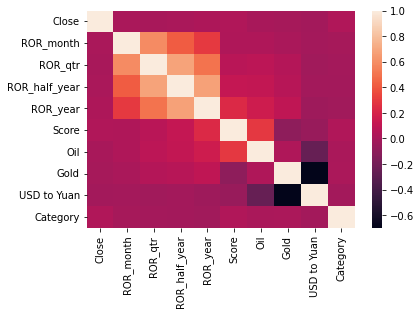

In [59]:
# Korelacja zmiennych
corr = df_clear.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

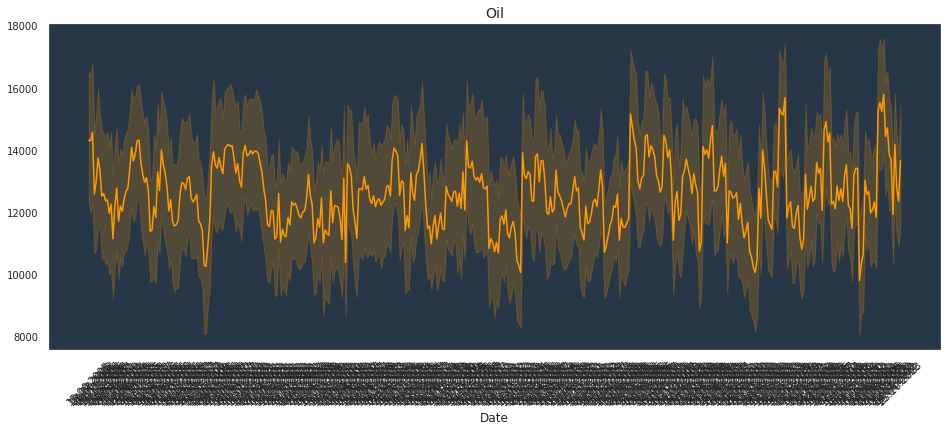

In [60]:
# Oil, Gold, USD to Yuan na przestrzeni lat
plt.figure(figsize=(16,6))
sns.set(rc={"axes.facecolor":"#283747", "axes.grid":False,'xtick.labelsize':10,'ytick.labelsize':10})
plt.title("Oil",fontsize = 14)
plt.xticks(rotation=45) # Rotating X tickts by 45 degrees
sns.lineplot(x = df_clear["Date"], y = df_clear["Oil"].index.values  , color = '#ff9900')
plt.show()

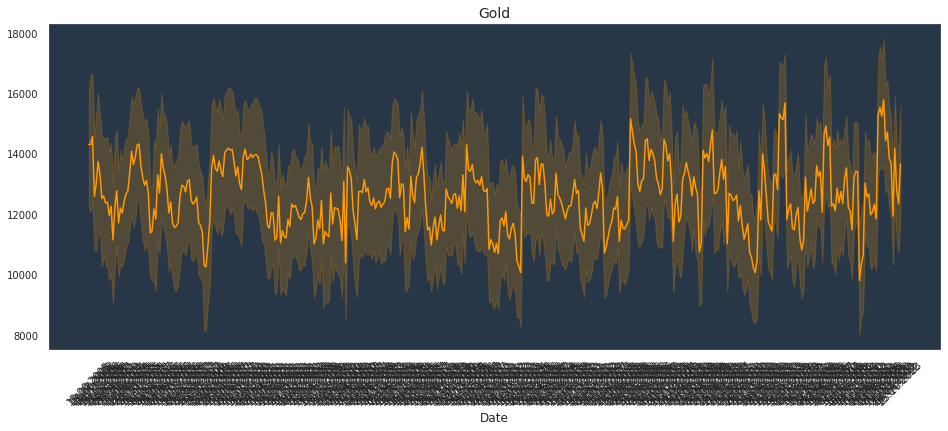

In [19]:
# Gold
plt.figure(figsize=(16,6))
sns.set(rc={"axes.facecolor":"#283747", "axes.grid":False,'xtick.labelsize':10,'ytick.labelsize':10})
plt.title("Gold",fontsize = 14)
plt.xticks(rotation=45) # Rotating X tickts by 45 degrees
sns.lineplot(x = df_clear["Date"], y = df_clear["Gold"].index.values  , color = '#ff9900')
plt.show()

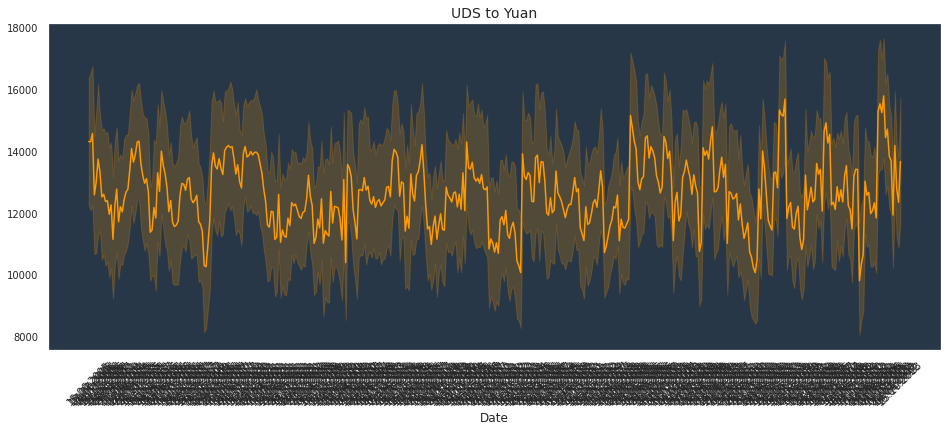

In [20]:
# USD to Yuan
plt.figure(figsize=(16,6))
sns.set(rc={"axes.facecolor":"#283747", "axes.grid":False,'xtick.labelsize':10,'ytick.labelsize':10})
plt.title("UDS to Yuan",fontsize = 14)
plt.xticks(rotation=45) # Rotating X tickts by 45 degrees
sns.lineplot(x = df_clear["Date"], y = df_clear["USD to Yuan"].index.values  , color = '#ff9900')
plt.show()

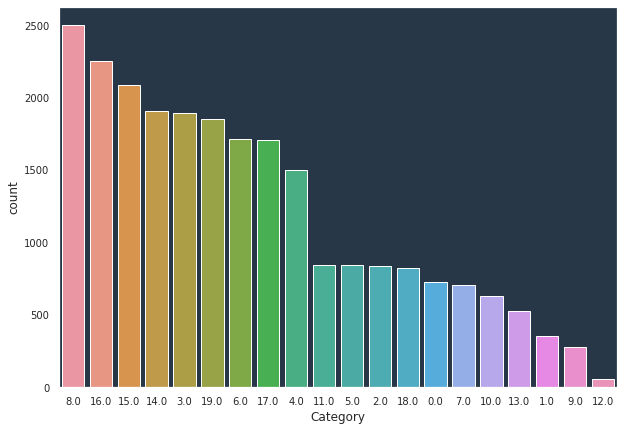

In [69]:
# Liczba kategorii
plt.figure(figsize=(10,7))
sns.countplot(df_clear['Category'], order=df_clear['Category'].value_counts().index)
plt.show()

# Prognozowanie - okres roczny
Utworzono trzy modele prognozujące wartość ROR w okresie rocznym:


*   las losowy
*   xgboost
*   Neural Network





In [6]:
# Wybór zmiennych objaśnianych i objaśniających
y = 'ROR_year'
x_cols = [col for col in df_clear.columns if col != y]
x_cols.remove('Date')
x_cols.remove('Comp')
x_cols.remove('ROR_qtr')
x_cols.remove('ROR_half_year')

In [7]:
# Dzielenie danych na treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(df_clear[x_cols], df_clear[y], test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16826, 7), (7212, 7), (16826,), (7212,))

## Las losowy

In [8]:
def print_result(y_test, y_pred):
    print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2)) 
    print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 2)) 
    print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2)) 
    print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2)) 
    print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))

In [9]:
# Hiperparametryzacja
regressor = RandomForestRegressor()
param_grid = {"max_depth":    [4, 8],
              "n_estimators": [150, 250, 400]}
              

search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)


In [10]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'max_depth': 8, 'n_estimators': 250}


In [11]:
# Random forest - po parametryzacji
randomState = 1111

randomForest = RandomForestRegressor(n_estimators= search.best_params_["n_estimators"], max_depth = search.best_params_["max_depth"], random_state=randomState)   
random_forest_model=randomForest.fit(X_train, y_train)  #trenowanie modelu
y_pred_original= randomForest.predict(X_test)  #predykcja

print_result(y_test, y_pred_original)

Mean absolute error = 0.14
Mean squared error = 0.04
Median absolute error = 0.11
Explain variance score = 0.38
R2 score = 0.38


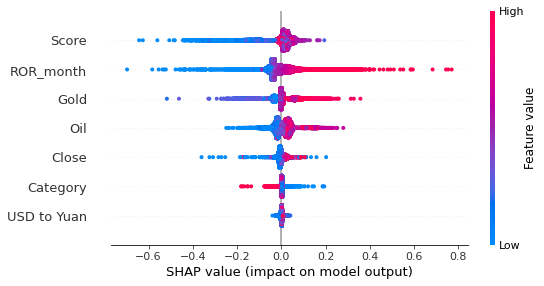

In [13]:
X = df_clear[x_cols]

explainer = shap.TreeExplainer(random_forest_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X) 

## XGBoost

In [ ]:
regressor=xgb.XGBRegressor()

param_grid = {"max_depth":    [4, 8],
              "n_estimators": [150, 250, 400],
              "learning_rate": [0.01, 0.015]}

search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

In [42]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 8, 'n_estimators': 400}


In [43]:
# Trenowanie modelu i predykcja
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"])

xgb_model = regressor.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

In [44]:
print_result(y_test, xgb_y_pred)

Mean absolute error = 0.13
Mean squared error = 0.03
Median absolute error = 0.1
Explain variance score = 0.47
R2 score = 0.47


# NN Reggresion

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler =  MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

In [53]:
model = Sequential()

input_dim        = X_train.shape[1] # liczba neuronów w warstie imput
n_neurons        =  25       # liczba neuronów w hidden layer
epochs           = 150       # liczba cykli treningowych

model.add(Dense(n_neurons, input_dim=input_dim, 
                kernel_initializer='normal', 
                activation='relu'))

# do modelu dodajemy wartwę "output" zawierającej 1 neuron
model.add(Dense(1, kernel_initializer='normal'))

# kompilacja modelu. Funkcja straty minimalizowana za pomocą MSE.
model.compile(loss='mean_squared_error', optimizer='adam')

In [54]:
model.fit(X_train, y_train, epochs=epochs, verbose=0)

In [55]:
# Predykcja
predictions = model.predict(X_test)

In [56]:
print_result(y_test, predictions)

Mean absolute error = 0.15
Mean squared error = 0.04
Median absolute error = 0.12
Explain variance score = 0.3
R2 score = 0.28


# Prognozowanie - okres półroczny


In [14]:
y = 'ROR_half_year'
x_cols = [col for col in df_clear.columns if col != y]
x_cols.remove('Date')
x_cols.remove('Comp')
x_cols.remove('ROR_qtr')
x_cols.remove('ROR_year')

In [15]:
# Dzielenie danych na treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(df_clear[x_cols], df_clear[y], test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16826, 7), (7212, 7), (16826,), (7212,))

## Las losowy

In [16]:
# Hiperparametryzacja
regressor = RandomForestRegressor()
param_grid = {"max_depth":    [4, 8],
              "n_estimators": [150, 250, 400]}
              

search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

In [73]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'max_depth': 8, 'n_estimators': 400}


In [17]:
# Random forest - po parametryzacji
randomState = 1111

randomForest = RandomForestRegressor(n_estimators= search.best_params_["n_estimators"], max_depth = search.best_params_["max_depth"], random_state=randomState)   
random_forest_model=randomForest.fit(X_train, y_train)  #trenowanie modelu
y_pred_original= randomForest.predict(X_test)  #predykcja

print_result(y_test, y_pred_original)

Mean absolute error = 0.11
Mean squared error = 0.02
Median absolute error = 0.08
Explain variance score = 0.35
R2 score = 0.35


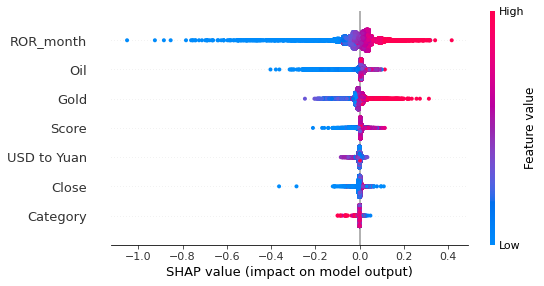

In [18]:
X = df_clear[x_cols]

explainer = shap.TreeExplainer(random_forest_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X) 

## XGBoost

In [ ]:
regressor=xgb.XGBRegressor()

param_grid = {"max_depth":    [4, 8],
              "n_estimators": [150, 250, 400],
              "learning_rate": [0.01, 0.015]}

search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

In [76]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 8, 'n_estimators': 400}


In [77]:
# Trenowanie modelu i predykcja
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"])

xgb_model = regressor.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)
print_result(y_test, xgb_y_pred)

[16:17:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean absolute error = 0.1
Mean squared error = 0.02
Median absolute error = 0.08
Explain variance score = 0.44
R2 score = 0.44


## NN

In [78]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

model = Sequential()

input_dim        = X_train.shape[1] # liczba neuronów w warstie imput
n_neurons        =  25       # liczba neuronów w hidden layer
epochs           = 150       # liczba cykli treningowych

model.add(Dense(n_neurons, input_dim=input_dim, 
                kernel_initializer='normal', 
                activation='relu'))

# do modelu dodajemy wartwę "output" zawierającej 1 neuron
model.add(Dense(1, kernel_initializer='normal'))

# kompilacja modelu. Funkcja straty minimalizowana za pomocą MSE.
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Predykcja
predictions = model.predict(X_test)

# Wyniki
print_result(y_test, predictions)

Mean absolute error = 0.12
Mean squared error = 0.03
Median absolute error = 0.09
Explain variance score = 0.26
R2 score = 0.21


# Horyzont kwartalny

In [21]:
y = 'ROR_qtr'
x_cols = [col for col in df_clear.columns if col != y]
x_cols.remove('Date')
x_cols.remove('Comp')
x_cols.remove('ROR_half_year')
x_cols.remove('ROR_year')

In [22]:
# Dzielenie danych na treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(df_clear[x_cols], df_clear[y], test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16826, 7), (7212, 7), (16826,), (7212,))

## Las losowy

In [23]:
# Hiperparametryzacja
regressor = RandomForestRegressor()
param_grid = {"max_depth":    [4, 8],
              "n_estimators": [150, 250, 400]}
              

search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

In [84]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'max_depth': 8, 'n_estimators': 400}


In [24]:
# Random forest - po parametryzacji
randomState = 1111

randomForest = RandomForestRegressor(n_estimators= search.best_params_["n_estimators"], max_depth = search.best_params_["max_depth"], random_state=randomState)   
random_forest_model=randomForest.fit(X_train, y_train)  #trenowanie modelu
y_pred_original= randomForest.predict(X_test)  #predykcja

print_result(y_test, y_pred_original)

Mean absolute error = 0.07
Mean squared error = 0.01
Median absolute error = 0.05
Explain variance score = 0.43
R2 score = 0.43


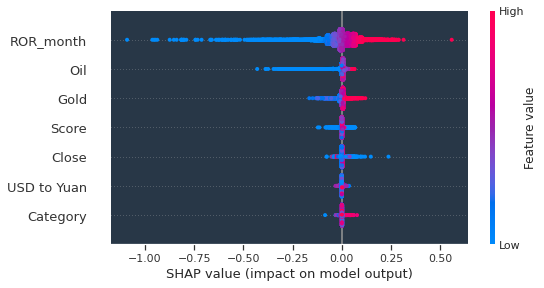

In [25]:
#X = df_clear[x_cols]

explainer = shap.TreeExplainer(random_forest_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X) 

## XGBoost

In [ ]:
regressor=xgb.XGBRegressor()

param_grid = {"max_depth":    [4, 8],
              "n_estimators": [150, 250, 400],
              "learning_rate": [0.01, 0.015]}

search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

In [87]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 8, 'n_estimators': 400}


In [88]:
# Trenowanie modelu i predykcja
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"])

xgb_model = regressor.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)
print_result(y_test, xgb_y_pred)

[16:30:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean absolute error = 0.07
Mean squared error = 0.01
Median absolute error = 0.05
Explain variance score = 0.52
R2 score = 0.52


## NN

In [89]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

model = Sequential()

input_dim        = X_train.shape[1] # liczba neuronów w warstie imput
n_neurons        =  25       # liczba neuronów w hidden layer
epochs           = 150       # liczba cykli treningowych

model.add(Dense(n_neurons, input_dim=input_dim, 
                kernel_initializer='normal', 
                activation='relu'))

# do modelu dodajemy wartwę "output" zawierającej 1 neuron
model.add(Dense(1, kernel_initializer='normal'))

# kompilacja modelu. Funkcja straty minimalizowana za pomocą MSE.
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Predykcja
predictions = model.predict(X_test)

# Wyniki
print_result(y_test, predictions)

Mean absolute error = 0.1
Mean squared error = 0.02
Median absolute error = 0.08
Explain variance score = 0.28
R2 score = 0.1
